# Course: Machine Learning1 - kNN
<div class="alert alert-block alert-info">
Project: 01 </br> </br>
Team members
<ul>
<li>Mauro Travieso Pena</li>
<li>Quoc Huy Luong</li>
<li>Ngoc Bao Tran</li>
<ul>
</div>

## Exploratory Data Analysis



### Context
This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.


### Content

#### Anime.csv

**anime_id** - myanimelist.net's unique id identifying an anime.

**name** - full name of anime.

**genre** - comma separated list of genres for this anime.

**type** - movie, TV, OVA, etc.

**episodes** - how many episodes in this show. (1 if movie).

**rating** - average rating out of 10 for this anime.

**members** - number of community members that are in this anime's "group".

##### Dataset reference: https://www.kaggle.com/CooperUnion/anime-recommendations-database?fbclid=IwAR3sXr48_xQHp8NgF9AyXuVf0RGwTkFw8bfkRoXda6zix9rQsevpya8JDOM#rating.csv

## Step 1 - Importing the DataFrame (CSV to DataFrame)

### Libraries

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import preprocessing

#### MyPCA

In [2]:
def myPCA(data,n):
    pca = PCA(n_components=n)
    pca.fit(data)
    df = pca.transform(data)
    PCA_Data = pd.DataFrame(df)
    return PCA_Data

#### myNormalize

In [3]:
def myNormalize(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    Normalized_Data = min_max_scaler.fit_transform(data)
    Normalized_Data = pd.DataFrame(Normalized_Data)
    return Normalized_Data

#### myEncode

In [4]:
def myEncode(data,col): 
    NewData_Encode = data.copy()
    NewData_Encode = pd.get_dummies(NewData_Encode, columns=col, prefix = col)
    return NewData_Encode


#### myCleanAndTransformData

In [5]:
def myCleanAndTransformData(data):
    
    #Drop null rows
    NewData = data.dropna()
    #Remove unknown ata
    NewData = NewData[NewData['episodes']!='Unknown']
    #Add a new column rating class 
    NewData['Class']=1
    # 1: High
    # or 0: Low based on rating
    NewData.loc[NewData['rating'] >= NewData['rating'].mean(), 'Class'] = 1
    NewData.loc[NewData['rating'] < NewData['rating'].mean(), 'Class'] = 0
    
    #Split genre values into rows
    NewData = pd.DataFrame(NewData.genre.str.split(',').tolist(), index=[NewData.anime_id,NewData.type,NewData.episodes,NewData.rating,NewData.members,NewData.Class]).stack()
    NewData = NewData.reset_index([0,'anime_id','type','episodes','rating','members','Class'])
    NewData.columns=['anime_id','type','episodes','rating','members','Class','genre']
    
    #Encode type feature: 6 unique values
    NewData = myEncode(NewData,['type'])
 
    #Encode genre feature: 82 unique values
    NewData = myEncode(NewData,['genre'])
 
     #Drop anmie_id,rating,Class
    NewData = NewData.drop(['rating'],axis=1)
    NewData = NewData.drop(columns=['anime_id'])
    #NewData = NewData.drop(columns=['episodes'])  
    
    return NewData


#### mySplitData

In [6]:
def mySplitData(X_Data,Y_Data,test_size,random_state):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_Data, Y_Data, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def mySplitDataByTrainSize(X_Data,Y_Data,train_size,random_state):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_Data, Y_Data, train_size=train_size, random_state=random_state)
    X_train, X_test, y_train, y_test = mySplitData(X_train,y_train,0.33,random_state)
    return X_train, X_test, y_train, y_test

### Datasets


In [7]:
df = pd.read_csv('../data/anime.csv')
df.head()
RawData = df.copy()

## Checking the structure of the columns

### Visualizing the number of colums and features' names associated to the dataset

In [8]:
RawData.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

In [9]:
print("Dimensions of DataFrame: {}".format(RawData.shape))

Dimensions of DataFrame: (12294, 7)


### The Dataset counts on 12'294 rows, grouped in 7 columns.

### Obtaining a sample of the associated data 

In [10]:
RawData.sample(5)

,anime_id,name,genre,type,episodes,rating,members
6794,32879,Norn9: Norn+Nonet Recap,"Adventure, Fantasy, Josei, Romance",Special,1,5.93,2109
9542,26107,Miitsuketa!,"Drama, Kids",OVA,1,7.67,48
2531,11841,Qin Shiming Yue Zhi: Ye Jin Tianming,"Action, Fantasy, Historical, Martial Arts",TV,18,7.24,366
4261,15125,Teekyuu,"Comedy, School, Shounen, Sports",TV,12,6.77,30291
1413,27631,God Eater,"Action, Fantasy, Military, Sci-Fi",TV,13,7.55,192433


### It is appreciated the nature of the columns (Categorical and Numerical).

## Descriptive statistics summary of the variable of the dataset features 

In [11]:
print(RawData.dtypes)

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object


### Number of unique values per feature

In [12]:
RawData.nunique()

anime_id    12294
name        12292
genre        3264
type            6
episodes      187
rating        598
members      6706
dtype: int64

### Number of total values per feature 

In [13]:
RawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12232 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


#### When complete, every feature should contain a maximum of 12'294 of data. However, it can be seeing that some features doesn't reach that value. It indicates the pressence of missing values.

## Exploring the missing values

type       25
genre      62
rating    230
dtype: int64

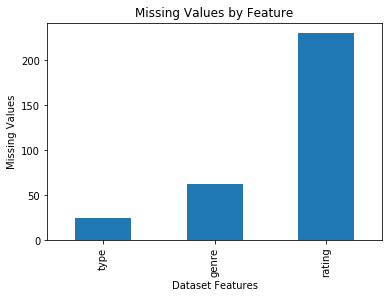

In [14]:
missing = RawData.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar().set_title("Missing Values by Feature")
missing.plot.bar().set_xlabel('Dataset Features')
missing.plot.bar().set_ylabel('Missing Values')
missing.head()

#### The category with most missing values is found in 'rating' followed by 'gender' and 'type' respectively.

## Exploring the whole dataset statistically.

In [15]:
RawData.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [16]:
RawData['anime_id'].describe()

count    12294.000000
mean     14058.221653
std      11455.294701
min          1.000000
25%       3484.250000
50%      10260.500000
75%      24794.500000
max      34527.000000
Name: anime_id, dtype: float64

In [17]:
RawData['anime_id'].unique()

array([32281,  5114, 28977, ...,  5621,  6133, 26081])

In [18]:
RawData['name'].describe()

count                       12294
unique                      12292
top       Shi Wan Ge Leng Xiaohua
freq                            2
Name: name, dtype: object

In [19]:
RawData['name'].unique()

array(['Kimi no Na wa.', 'Fullmetal Alchemist: Brotherhood', 'Gintama°',
       ..., 'Violence Gekiga David no Hoshi',
       'Violence Gekiga Shin David no Hoshi: Inma Densetsu',
       'Yasuji no Pornorama: Yacchimae!!'], dtype=object)

In [20]:
RawData['genre'].describe()

count      12232
unique      3264
top       Hentai
freq         823
Name: genre, dtype: object

In [21]:
RawData['genre'].unique()

array(['Drama, Romance, School, Supernatural',
       'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
       'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
       ..., 'Hentai, Sports', 'Drama, Romance, School, Yuri',
       'Hentai, Slice of Life'], dtype=object)

In [22]:
RawData['type'].describe()

count     12269
unique        6
top          TV
freq       3787
Name: type, dtype: object

In [23]:
RawData['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

In [24]:
RawData['episodes'].describe()

count     12294
unique      187
top           1
freq       5677
Name: episodes, dtype: object

In [25]:
RawData['episodes'].unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

In [26]:
RawData['rating'].describe()

count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

In [27]:
RawData['rating'].unique()

array([ 9.37,  9.26,  9.25,  9.17,  9.16,  9.15,  9.13,  9.11,  9.1 ,
        9.06,  9.05,  9.04,  8.98,  8.93,  8.92,  8.88,  8.84,  8.83,
        8.82,  8.81,  8.8 ,  8.78,  8.77,  8.76,  8.75,  8.74,  8.73,
        8.72,  8.71,  8.69,  8.68,  8.67,  8.66,  8.65,  8.64,  8.62,
        8.61,  8.6 ,  8.59,  8.58,  8.57,  8.56,  8.55,  8.54,  8.53,
        8.52,  8.51,  8.5 ,  8.49,  8.48,  8.47,  8.46,  8.45,  8.44,
        8.43,  8.42,  8.41,  8.4 ,  8.39,  8.38,  8.37,  8.36,  8.35,
        8.34,  8.33,  8.32,  8.31,  8.3 ,  8.29,  8.28,  8.27,  8.26,
        8.25,  8.24,  8.23,  8.22,  8.21,  8.2 ,  8.19,  8.18,  8.17,
        8.16,  8.15,  8.14,  8.13,  8.12,  8.11,  8.1 ,  8.09,  8.08,
        8.07,  8.06,  8.05,  8.04,  8.03,  8.02,  8.01,  8.  ,  7.99,
        7.98,  7.97,  7.96,  7.95,  7.94,  7.93,  7.92,  7.91,  7.9 ,
        7.89,  7.88,  7.87,  7.86,  7.85,  7.84,  7.83,  7.82,  7.81,
        7.8 ,  7.79,  7.78,  7.77,  7.76,  7.75,  7.74,  7.73,  7.72,
        7.71,  7.7 ,

In [28]:
RawData['members'].describe()

count    1.229400e+04
mean     1.807134e+04
std      5.482068e+04
min      5.000000e+00
25%      2.250000e+02
50%      1.550000e+03
75%      9.437000e+03
max      1.013917e+06
Name: members, dtype: float64

In [29]:
RawData['members'].unique()

array([200630, 793665, 114262, ...,  27411,  57355,    652])

## Dropping the rows with missing data ('Na')

In [30]:
df = df.dropna()

In [31]:
df['rating'].describe()

count    12017.000000
mean         6.478264
std          1.023857
min          1.670000
25%          5.890000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

## Exploring the Numerical Features

### Feature: **rating**

In [32]:
RawData['rating'].describe()

count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

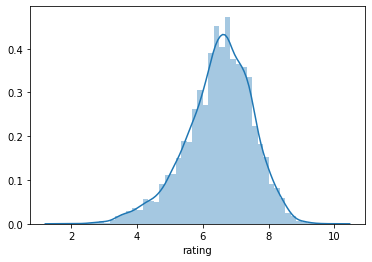

In [33]:
sns.distplot(df['rating']);

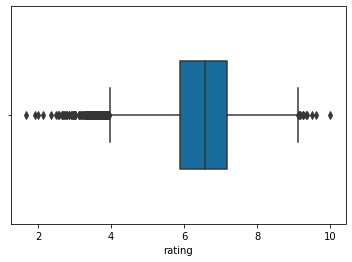

In [34]:
bplot = sns.boxplot(x='rating', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")

### Feature: **members**

In [35]:
df['members'].describe()

count    1.201700e+04
mean     1.834888e+04
std      5.537250e+04
min      1.200000e+01
25%      2.250000e+02
50%      1.552000e+03
75%      9.588000e+03
max      1.013917e+06
Name: members, dtype: float64

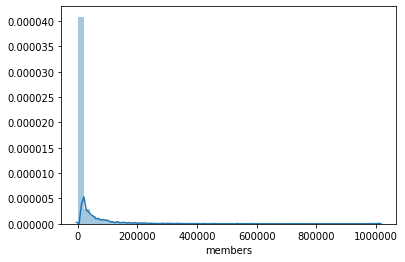

In [36]:
sns.distplot(df['members']);

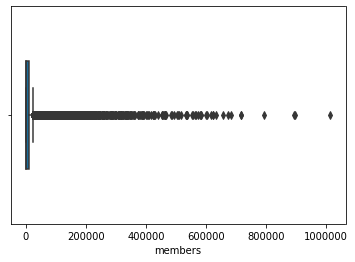

In [37]:
bplot = sns.boxplot(x='members', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")

### Feature: **episodes**

In [38]:
df['episodes'].describe()

count     12017
unique      187
top           1
freq       5571
Name: episodes, dtype: object

### The Numerical feature 'episodes' is declared as an object and also, contains Categorical data which is required to  be removed from the rows in the dataset.

In [39]:
df = df[df['episodes']!='Unknown']

In [40]:
df['episodes'].unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       '39', '101', '47', '50', '62', '33', '112', '23', '3', '94', '6',
       '8', '14', '7', '40', '15', '203', '77', '291', '120', '102', '96',
       '38', '79', '175', '103', '70', '153', '45', '5', '21', '63', '52',
       '28', '145', '36', '69', '60', '178', '114', '35', '61', '34',
       '109', '20', '9', '49', '366', '97', '48', '78', '358', '155',
       '104', '113', '54', '167', '161', '42', '142', '31', '373', '220',
       '46', '195', '17', '1787', '73', '147', '127', '16', '19', '98',
       '150', '76', '53', '124', '29', '115', '224', '44', '58', '93',
       '154', '92', '67', '172', '86', '30', '276', '59', '72', '330',
       '41', '105', '128', '137', '56', '55', '65', '243', '193', '18',
       '191', '180', '91', '192', '66', '182', '32', '164', '100', '296',
       '694', '95', '68', '117', '151', '130', '87', '170

### Now, the feature can be converted from object (Categorical) to int (Numerical), and explored.

https://stackoverflow.com/questions/48094854/python-convert-object-to-float

In [41]:
df['episodes'] = df.episodes.astype(int)

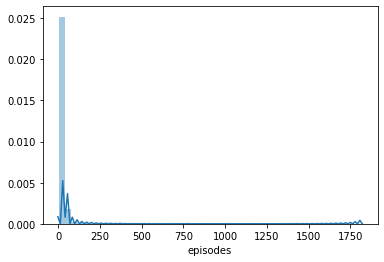

In [42]:
sns.distplot(df['episodes']);

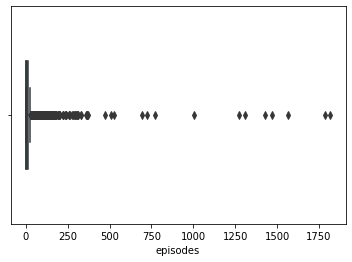

In [43]:
bplot = sns.boxplot(x='episodes', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")

### Besides, the Numerical Features statistical behavior is observed.

In [44]:
print("Skewness Episodes: %f" % df['episodes'].skew())

Skewness Episodes: 23.277143


In [45]:
print("Skewness Rating: %f" % df['rating'].skew())

Skewness Rating: -0.538142


In [46]:
print("Skewness Members: %f" % df['members'].skew())

Skewness Members: 6.588423


### Negative values for the skewness indicate data that are skewed left. Possitive values mean the opposite. By skewed left, we mean that the left tail is long relative to the right tail. 

### When exploring rating, the value is relatively close to zero, the distribution is almost symetrical ( < |0.5|).

### Features: episodes and members show an important amount of positive skewness.

In [47]:
print("Kurtosis Episodes: %f" % df['episodes'].kurt())

Kurtosis Episodes: 726.254496


In [48]:
print("Kurtosis Rating: %f" % df['rating'].kurt())

Kurtosis Rating: 0.505835


In [49]:
print("Kurtosis Members: %f" % df['members'].kurt())

Kurtosis Members: 61.400628


### Kurtosis is a measure of whether the distribution is too peaked (a very narrow distribution with most of the responses in the center.

### It means the effect of the tails on the whole distribution contribution.

### Again, rating shows a value relatively close to zero, which means that the statistical behavior of this feture seems a balanced Gauss bell.

### Features: episodes and members show a significative amount of kurtosis. 

In [50]:
print("Dimensions of DataFrame: {}".format(df.shape))


Dimensions of DataFrame: (11830, 7)


## Removing the Outliers.

### Due to the previous observation of the respective boxplots, it can be seen the pressence of outliers on every Numerical feature. In the following lines of codes, they can be count to decide its effects in the distribution.

### We will use Z-score function defined in scipy library to detect the outliers.The Z-score states that the dataset is transformed in a matrix which values more than three standard deviations represent outliers. 

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [51]:
from scipy import stats
import numpy as np
df = df.drop(columns=['anime_id','name','genre','type'])
z = np.abs(stats.zscore(df))
print(z)

[[ 0.24390475  2.83130101  3.28918118]
 [ 1.09381288  2.7233631  13.99975827]
 [ 0.81777591  2.71355056  1.72932194]
 ...
 [ 0.18020391  1.57452817  0.33036483]
 [ 0.24390475  1.4764028   0.3311595 ]
 [ 0.24390475  1.00540102  0.3317555 ]]


### Using this line of code, the outliers of the whole dataset are removed as a whole (taking into account every Numerical feature in respect to the others).

In [52]:
df = df[(z < 3).all(axis=1)]
df.head()

,episodes,rating,members
2,51,9.25,114262
4,51,9.16,151266
5,10,9.15,93351
7,110,9.11,80679
8,1,9.10,72534


### As a result, the new Dataset only loses few rows since the previous operation performed (-3.25%)

In [53]:
# Add a new column rating class 
df['Class']=1 #df['rating']
df.sample(5)

,episodes,rating,members,Class
9096,31,7.00,98,1
892,1,7.78,4499,1
7201,2,5.64,653,1
12010,3,5.73,1138,1
11508,1,6.50,2438,1


In [54]:
# 1: High
# or 0: Low based on rating
df.loc[df['rating'] >= df['rating'].mean(), 'Class'] = 1
df.loc[df['rating'] < df['rating'].mean(), 'Class'] = 0

In [55]:
df.sample(5)

,episodes,rating,members,Class
7686,1,5.14,445,0
3751,39,6.90,1184,1
8363,39,6.79,168,1
2667,26,7.20,2297,1
5648,51,6.39,3229,0


In [56]:
print(df.dtypes)

episodes      int64
rating      float64
members       int64
Class         int64
dtype: object


### Split up the dataset into inputs (X) and target (y)

### Drop the Categorical features as well as the class label (rating)

In [57]:
#X = df.drop(columns=['anime_id','name','genre','type','rating','Class'])
X = df.drop(columns=['rating','Class'])

In [58]:
X.head()

,episodes,members
2,51,114262
4,51,151266
5,10,93351
7,110,80679
8,1,72534


## Normalization

### kNN and almost any classification algorithm is very sensitive to values ranges due to the distance based, so it is required to normalize the numerical features. 

### For the possitive nature of the values related to the features in real life, it makes sense to use mim-max normalization. 

In [59]:
#from sklearn import preprocessing

#x = df.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#df = pandas.DataFrame(x_scaled)

#https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
#X=(X-X.mean())/X.std()
X=(X-X.min())/(X.max()-X.min())
X.head()

,episodes,members
2,0.328947,0.619187
4,0.328947,0.819742
5,0.059211,0.505853
7,0.717105,0.437173
8,0.000000,0.393029


### Separate the target values (class associated)

In [60]:
y = df['Class']

### Inspect the target values nature

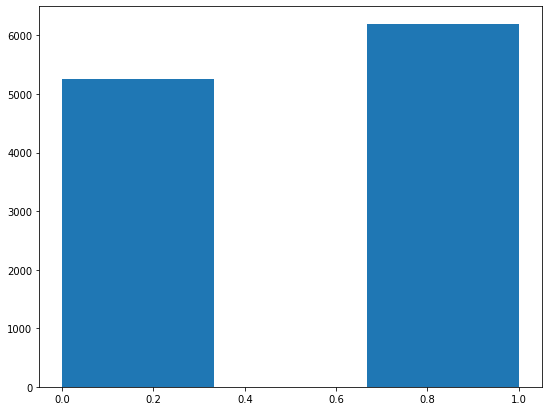

In [61]:
df['Class'].hist(bins=3,figsize=(9,7),grid=False)

In [62]:
y.sample(5)

3786     1
10006    0
6388     0
7590     0
8023     0
Name: Class, dtype: int64

In [63]:
y.describe()

count    11446.000000
mean         0.540538
std          0.498376
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Class, dtype: float64

##Split the dataset into train and test data

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#### This means that 20% of all the data will be used for testing, which leaves 80% of the data as training data for the model to learn from. Setting ‘random_state’ to 1 ensures that we get the same split each time so we can reproduce our results.

#### Setting ‘stratify’ to y makes our training split represent the proportion of each value in the y variable. For example, in our dataset, if 25% of ratings are high and 75% are low, setting ‘stratify’ to y will ensure that the random split has 25% of ratings will be high and 75% will be low. But in or case, the split point (mean of y) is close to 50%.

## Building and training the model

#### Clean and Transform Data

In [66]:
Cleaned_Data = myCleanAndTransformData(RawData)
Y_Data = Cleaned_Data['Class']
X_Data = Cleaned_Data.drop(columns=['Class'])

#### Normalize  Data

In [67]:
Normalized_Data = myNormalize(X_Data)

#### PCA

In [68]:
n_components=40
PCA_Data = myPCA(Normalized_Data,n_components)
PCA_Data.head()



,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.311566,0.786508,-0.420821,0.005236,-0.078664,-0.049645,-0.062636,0.007171,-0.075349,-0.030938,...,-0.011714,-0.014519,0.009418,-0.010509,-0.008268,-0.004441,0.005016,-0.013924,-0.006877,-0.007706
1,-0.284842,0.763991,-0.412009,-0.010872,-0.110067,-0.087028,-0.096769,0.054629,-0.179466,-0.045545,...,-0.007195,-0.013013,0.006303,-0.011366,-0.008342,-0.001658,0.008166,-0.013391,-0.008518,-0.008376
2,-0.284838,0.767910,-0.395570,-0.007614,-0.091869,-0.059765,-0.062085,0.036505,-0.086830,-0.024721,...,-0.009438,-0.014719,0.006515,-0.012743,-0.009970,-0.005603,0.006313,-0.015353,-0.013110,-0.008292
3,-0.291600,0.777175,-0.408316,0.000301,-0.080828,-0.049799,-0.056889,0.019144,-0.070776,-0.027970,...,-0.012221,-0.015418,0.007570,-0.011313,-0.009431,-0.008051,0.004075,-0.014942,-0.012072,-0.010171
4,0.732145,-0.153155,-0.102203,-0.458230,0.816867,0.046173,0.015773,-0.064780,0.014353,-0.005003,...,0.007011,-0.013215,0.019790,-0.014619,-0.007255,0.025853,0.024249,-0.021688,-0.001597,0.048742


####----------------------------------------------------------------
#### Split  PCA_Data
####----------------------------------------------------------------

In [69]:
X_train, X_test, y_train, y_test  = mySplitData(PCA_Data,Y_Data,0.33,42)
X = X_train #PCA_Data
y = y_train

In [70]:
from sklearn.neighbors import KNeighborsClassifier# Create KNN classifier

In [71]:
knn = KNeighborsClassifier(n_neighbors = 3)# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

## Testing the model

In [72]:
#show first 5 model predictions on the test data
knn.predict(X_test)[0:5]

array([1, 1, 1, 0, 1])

### We can see that the model predicted ‘high rating’ for the first 3 and 5th animes in the test set and ‘low rating' for the 4th anime.

## Check accuracy of our model on the test data

In [73]:
knn.score(X_test, y_test)

0.7821296376000688

### Our model has an accuracy of approximately 78.16%. Which gives us a good start, but we will see how we can increase model performance following the steps below.

## k-Fold Cross-Validation

In [74]:
from sklearn.model_selection import cross_val_score
import numpy as np #create a new KNN model

In [75]:
knn_cv = KNeighborsClassifier(n_neighbors=3) #train model with cv of 5 

## CV score (accuracy) and the average of them

In [76]:
cv_scores = cross_val_score(knn_cv, X, y, cv=5) #print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.77575244 0.77718889 0.78248887 0.77290076 0.78053435]
cv_scores mean:0.7777730626532555


### Using cross-validation, our mean score is about 77.77%. This is a more accurate representation of how our model will perform on **unseen data** than our earlier testing using the holdout method.

## Hypertuning model parameters using GridSearchCV

### Hypertuning parameters is when you go through a process to find the optimal parameters for your model to improve accuracy. In our case, we will use GridSearchCV to find the optimal value for ‘n_neighbors’.

In [77]:
from sklearn.model_selection import GridSearchCV

In [78]:
#create new a knn model
knn2 = KNeighborsClassifier()

In [79]:
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 40)}

In [80]:
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

In [81]:
#fit model to data
knn_gscv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

## Check top performing n_neighbors value

### After training, we can check which of our values for ‘n_neighbors’ that we tested performed the best. To do this, we will call ‘best_params_’ on our model.

In [82]:
knn_gscv.best_params_

{'n_neighbors': 9}

### As we can see, 9 is the optimal value for ‘n_neighbors’. 

### We can use the ‘best_score_’ function to check the accuracy of our model when ‘n_neighbors’ is 9.

### ‘best_score_’ outputs the mean accuracy of the scores obtained through cross-validation.

## Check mean score for the top performing value of n_neighbors

In [83]:
knn_gscv.best_score_

0.7915959972862958

### Our model now, gives us an accuracy of 79.18% to be able to predict when new data is used.

## Confusion Matrix (get the predictions using the classifier which was fitted above)

In [84]:
#https://www.kaggle.com/amolbhivarkar/knn-for-classification-using-scikit-learn

#import confusion_matrix
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,2823,1282,4105
1,1249,6263,7512
All,4072,7545,11617


### The confusion matrix describes the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

### For, it can be appreciated that the rate of True Positives is 82.91%. It means, that the porbability of classifying a False Positive (missclassify) is about 17%

## Classification report

In [85]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.69      0.69      0.69      4105
           1       0.83      0.83      0.83      7512

    accuracy                           0.78     11617
   macro avg       0.76      0.76      0.76     11617
weighted avg       0.78      0.78      0.78     11617



### The classification report shows a representation of the main classification metrics (precision, recall, f1-score, support) on a per-class basis. 

### This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem. 

### For the model, the visual classification reports that it has stronger classification metrics which are balanced.



## ROC (Receiver Operating Characteristic) curve

https://www.kaggle.com/amolbhivarkar/knn-for-classification-using-scikit-learn


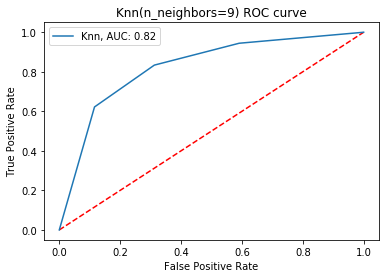

In [86]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'r--')
plt.plot(fpr,tpr, label='Knn, AUC: 0.82')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Knn(n_neighbors=9) ROC curve')
plt.show()

In [87]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8244852734204242

### The ROC curve demonstrates several things:

### 1) It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).

### 2) The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.

### 3)The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

### 4) The area under the curve is a measure of test accuracy. For our model, it represents 78.47%

## Complexity Curve / Validation Curve

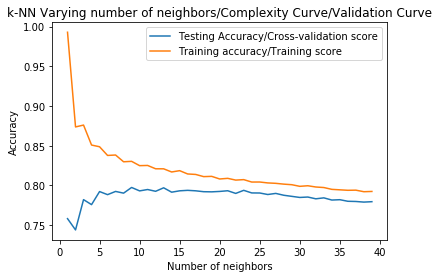

In [100]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,40)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

#Generate plot
plt.title('k-NN Varying number of neighbors/Complexity Curve/Validation Curve')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy/Cross-validation score')
plt.plot(neighbors, train_accuracy, label='Training accuracy/Training score')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

### We can observe above that we get maximum testing accuracy for k=9. 

### So, the KNeighborsClassifier with number of neighbors as 9, offers the best tunning for the model to generate accuracy predictions.

### We can see in the resulting visualization that a with number of neighbors less than 9 severely underfits the model on this data set because the training score and testing score climb together in this parameter range, and because of the high variability of cross validation on the test scores.

###  After k=9, the training and test scores converge, this is because from this value on, the model is beginning to overfit the training data, providing no generalizability to the model. 

### However, because the cross validation score does not necessarily decrease, the model is not suffering from high error due to variance.

## Learning Curve

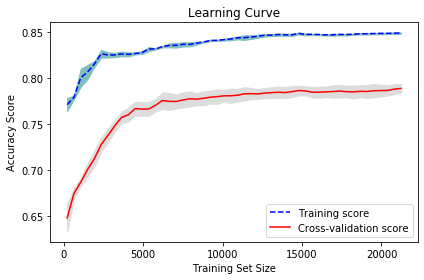

In [98]:
#https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
# Create CV training and test scores for various training set sizes
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#7fbfbf")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


### A learning curve shows the relationship of the training score vs the cross validated test score for an estimator with a varying number of training samples. This visualization is typically used two show two things:

### - How much the estimator benefits from more data (e.g. do we have “enough data” or will the estimator get better if used in an online fashion).

### - If the estimator is more sensitive to error due to variance vs. error due to bias.

### Due to the training and cross validation scores converge together as more data is added, then ***the model will probably not benefit from more data addition***. It means that is can ***produce the same predictions only with a dataset with a minimum dimension of 6'000 rows of data***. 

### It is important to mention that, the curves are plotted with the mean scores, however variability during cross-validation is shown with the shaded areas that represent a standard deviation above and below the mean for all cross-validations. 

### Moreover, if the model suffers from error due to bias, then there will likely be more variability around the training score curve. If the model suffers from error due to variance, then there will be more variability around the cross validated score.

## Exporting the model (Flask)

In [99]:
#from sklearn.externals import joblib
#joblib.dump(clf, 'my_knn_model.pkl', compress=9)

#from sklearn.externals import joblib
#model_clone = joblib.load('my_knn_model.pkl')
#y_pred_dt = model_clone.predict_proba(X_test)[:, 1]
#y_pred_dt

### Exporting a lazy learner model as kNN, requires the whole dataset to be exported as well to Flask, so it is impractical to do so. (It requires to reply the whole process in Flask to be able to predict) 